Tom Barclay's xoflares on EPIC-246301900

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner


In [2]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.2.0
1.0.4
3.7
1.0.1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightkurve-1.0.1-py3.7.egg/lightkurve/search.py:181: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


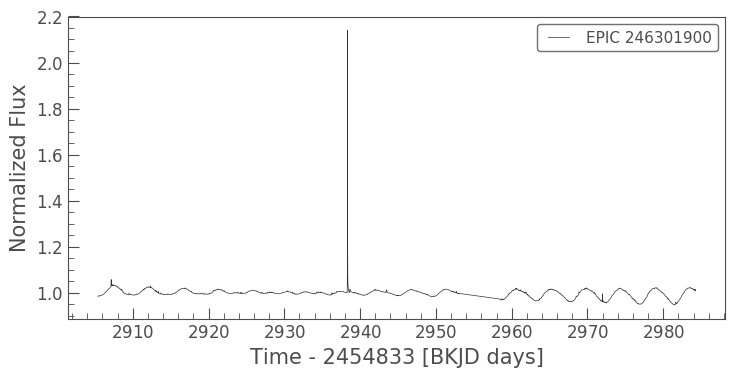

In [3]:
lc = lk.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())

In [4]:
lc = lc.to_lightcurve()
print(lc.flux.shape)

(3379,)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


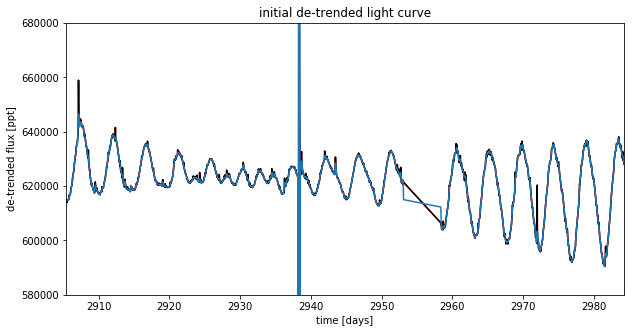

In [5]:
# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 13, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(lc.time.min(), lc.time.max());

Works pretty well, but as with the Gaussian Processes, it looks like we'll be better served splitting the time series in two.

In [6]:
# # find some flares
# mflare = resid < 2 * np.sqrt(np.mean(resid**2))
# cads = lc.cadenceno - lc.cadenceno[0]
# x = lc.time - ref_time
# y = resid #  we're working with the data with a savgol subtracted

# fidx = cads[~mflare][:-1][np.diff(cads[~mflare]) < 2]
# npts = np.array([])
# i = 0
# n = 1
# while True:
#     try:
#         if fidx[i + 1] == fidx[i] + n:
#             fidx = np.delete(fidx, i + 1)
#             n += 1
#         else:
#             npts = np.r_[npts, n+1]
#             i += 1
#             n = 1
#     except IndexError:
#         npts = np.r_[npts, n+1]
#         break
# tpeaks = np.array([x[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
# ampls = np.array([resid[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
# fwhms = np.asarray(npts) * (2/1440)
# npeaks = np.shape(tpeaks)[0]
# print(npeaks)

# find some flares
mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
cads = lc.cadenceno - lc.cadenceno[0]
x = lc.time - ref_time
y = resid #  we're working with the data with a savgol subtracted

fidx = cads[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
npts = np.array([])
i = 0
n = 1
while True:
    try:
        if fidx[i + 1] == fidx[i] + n:
            fidx = np.delete(fidx, i + 1)
            n += 1
        else:
            npts = np.r_[npts, n+1]
            i += 1
            n = 1
    except IndexError:
        npts = np.r_[npts, n+1]
        break
tpeaks = np.array([x[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
ampls = np.array([resid[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
fwhms = np.asarray(npts) * (2/1440)
npeaks = np.shape(tpeaks)[0]
print(npeaks)

2


**Pre Superflare**

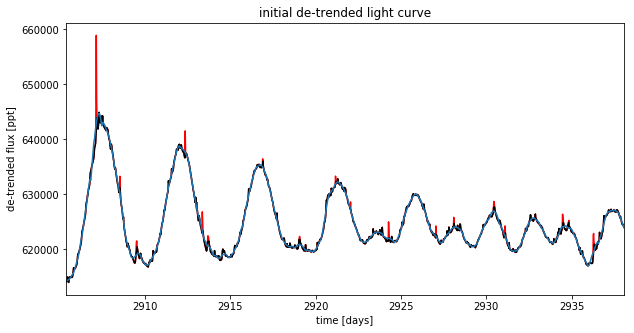

In [8]:
pre_flux = lc.flux[0:1513]
pre_time = lc.time[0:1513]
# get a smoothed version of the pre-flare light curve
smooth = savgol_filter(pre_flux, 31, polyorder=3)
resid = pre_flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(pre_time, pre_flux, "r")
plt.plot(pre_time[mask], pre_flux[mask], "k")
plt.plot(pre_time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(pre_time.min(), pre_time.max());

In [9]:
# find some flares
pre_cadenceno = lc.cadenceno[0:1513]
mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
cads = pre_cadenceno - pre_cadenceno[0]
ref_time_pre = 0.5 * (pre_time.min() + pre_time.max())
x = pre_time - ref_time_pre
y = resid #  we're working with the data with a savgol subtracted

fidx = cads[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
npts = np.array([])
i = 0
n = 1
while True:
    try:
        if fidx[i + 1] == fidx[i] + n:
            fidx = np.delete(fidx, i + 1)
            n += 1
        else:
            npts = np.r_[npts, n+1]
            i += 1
            n = 1
    except IndexError:
        npts = np.r_[npts, n+1]
        break
tpeaks = np.array([x[(pre_cadenceno - pre_cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
ampls = np.array([resid[(pre_cadenceno - pre_cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
fwhms = np.asarray(npts) * (2/1440)
npeaks = np.shape(tpeaks)[0]
print(npeaks)

7


**Check if times of predicted flares match up**

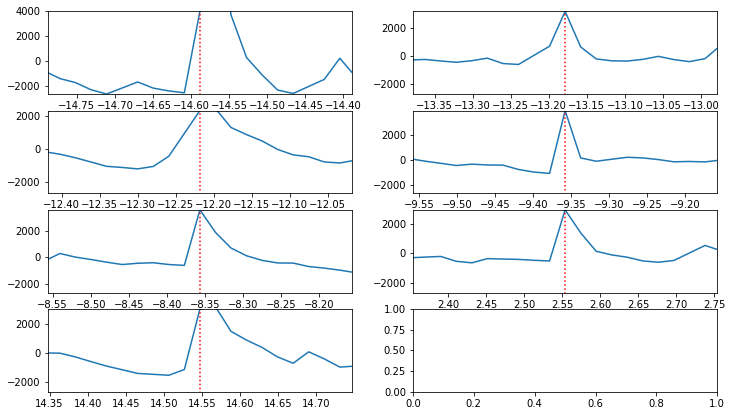

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

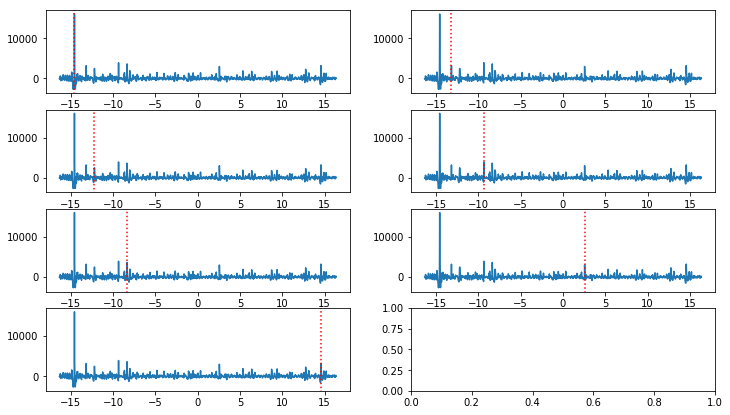

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    #ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))


In [13]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [14]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: ['mean', 'logFwhm']
message: Optimization terminated successfully.
logp: -40755.66497203426 -> -40755.66497203426
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -40755.66497203426 -> -40755.66497203426
optimizing logp for variables: ['logAmpl', 'logFwhm']
message: Optimization terminated successfully.
logp: -40755.66497203426 -> -40755.66497203426
optimizing logp for variables: ['tpeak']
message: Optimization terminated successfully.
logp: -40755.66497203426 -> -40755.66497203426


Average Loss = 11,475: 100%|██████████| 200000/200000 [08:28<00:00, 393.37it/s]  
Finished [100%]: Average Loss = 11,475


In [15]:
start[0]['tpeak'] - 0.2

array([-14.78493828, -13.38027513, -12.4137005 ,  -9.55898794,
        -8.5581086 ,   2.3524002 ,  14.35102898])

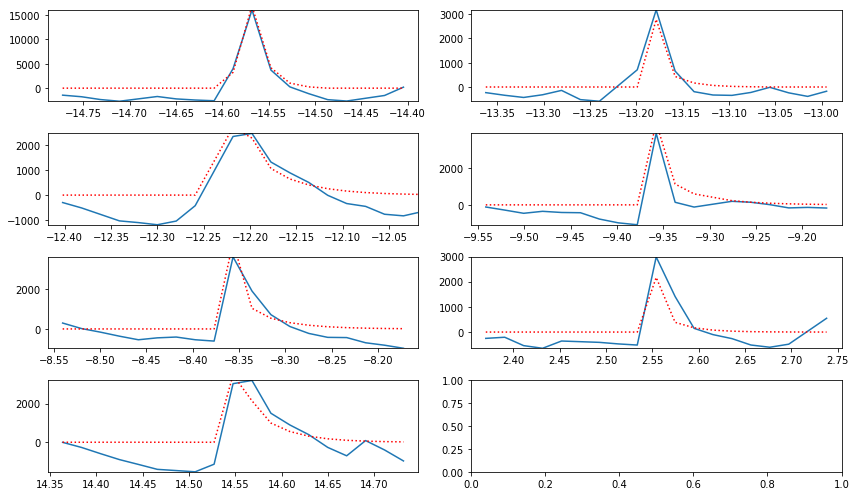

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#for i in range(npeaks):
#    ax = axes[i]
#    ax.plot(x, y)
#    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [35]:
# sampler = xo.PyMC3Sampler(window=200, start=0, finish=800)
# with model:
#     burnin = sampler.tune(tune=4000, start=map_soln, step_kwargs=dict(target_accept=0.9), init='advi_map')

In [18]:
# with model:
#     trace = sampler.sample(draws=2000)

with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]
Sampling 4 chains:  37%|███▋      | 3835/10400 [23:48<40:44,  2.69draws/s]  
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logAmpl__0,12.167456,0.103059,0.004305,11.956442,12.375783,512.968596,1.001773
logAmpl__1,8.588594,0.466535,0.013777,7.798850,9.513316,1002.485591,1.000054
logAmpl__2,9.098854,0.438011,0.017620,8.285205,10.012890,544.745071,1.003032
logAmpl__3,8.789599,0.477604,0.016532,8.025588,9.717521,713.488786,1.001355
logAmpl__4,9.088399,0.515193,0.023384,8.153142,10.025358,341.915815,1.005419
logAmpl__5,8.620816,0.503330,0.015988,7.804448,9.640853,777.634839,1.000157
logAmpl__6,9.630436,0.346921,0.014076,8.963813,10.282711,584.481243,1.001363
logFwhm__0,-5.592025,0.061982,0.002573,-5.719804,-5.463305,522.149935,1.001800
logFwhm__1,-5.681925,0.622183,0.016648,-6.989386,-4.566320,1488.868938,1.001650
logFwhm__2,-4.576157,0.362388,0.014531,-5.244593,-3.821656,539.100848,1.004636


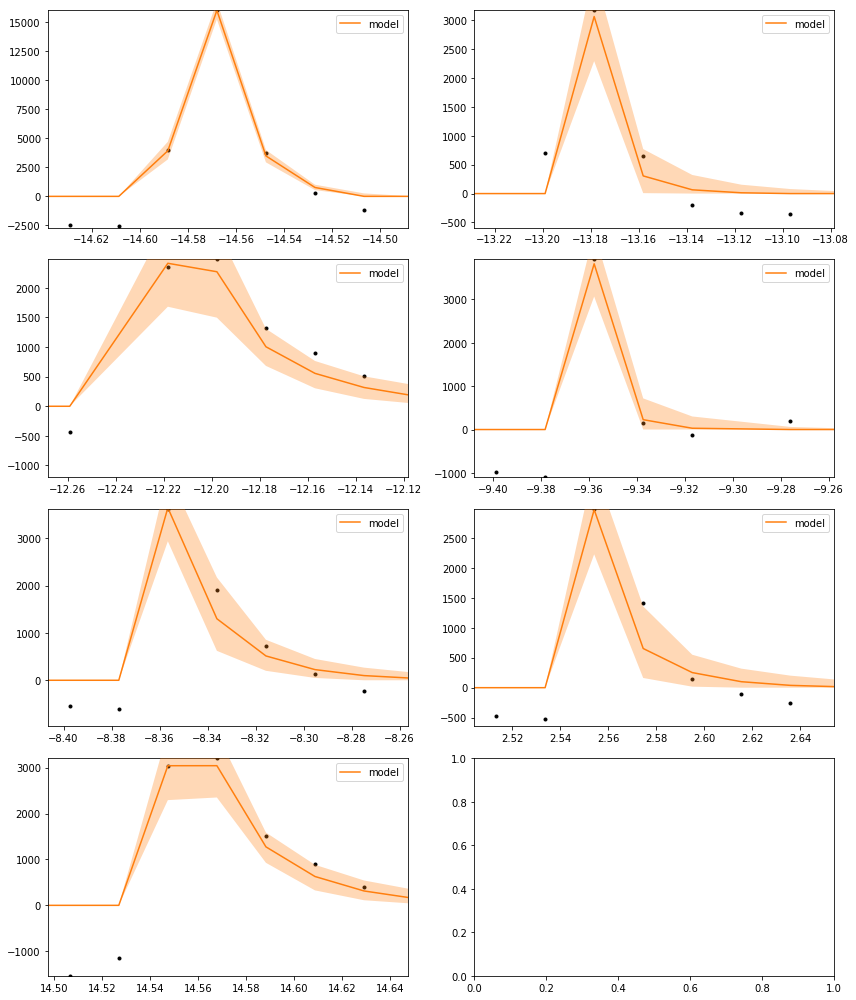

In [20]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()
    
fig.tight_layout()
#fig.savefig('flare-model.png')

In [131]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

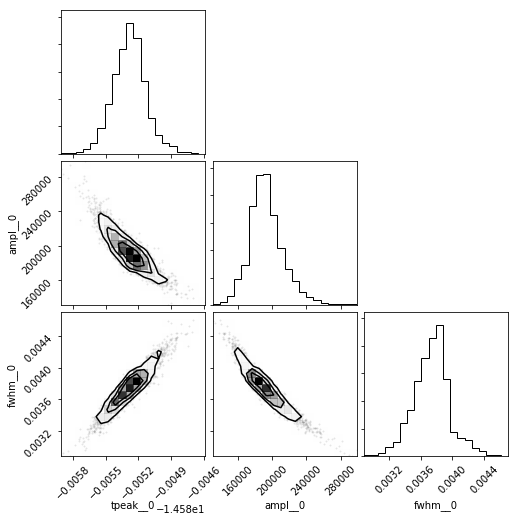

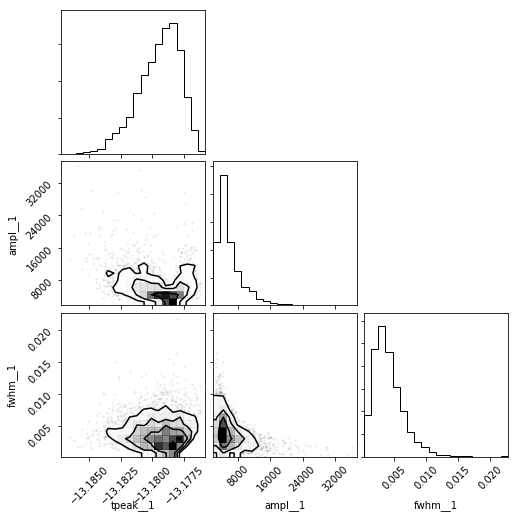

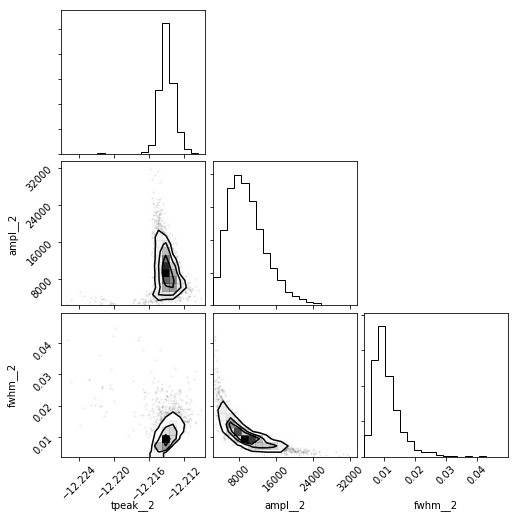

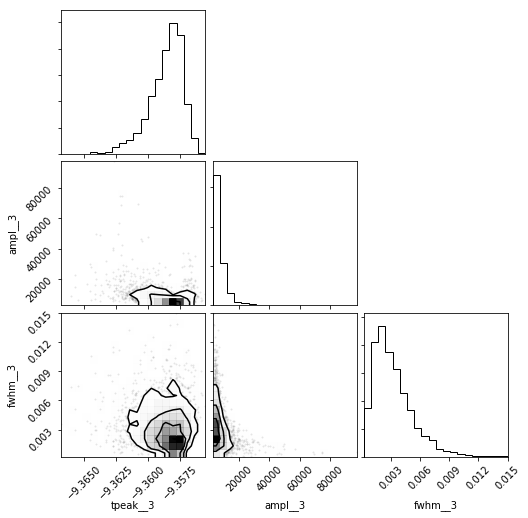

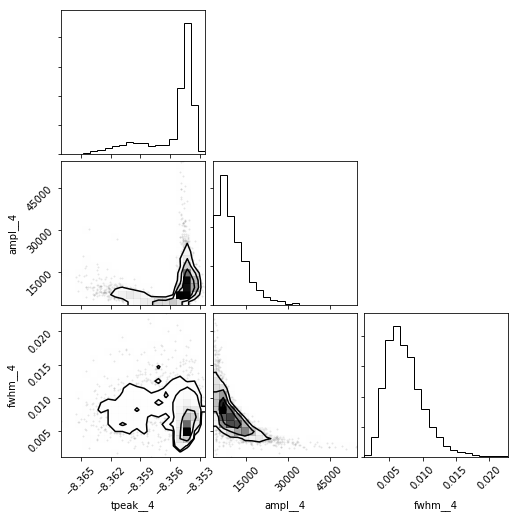

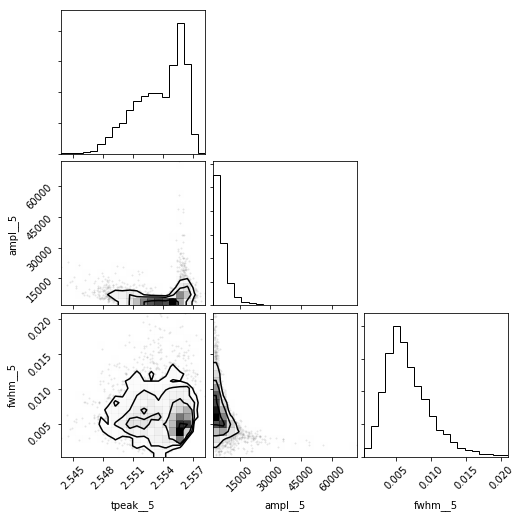

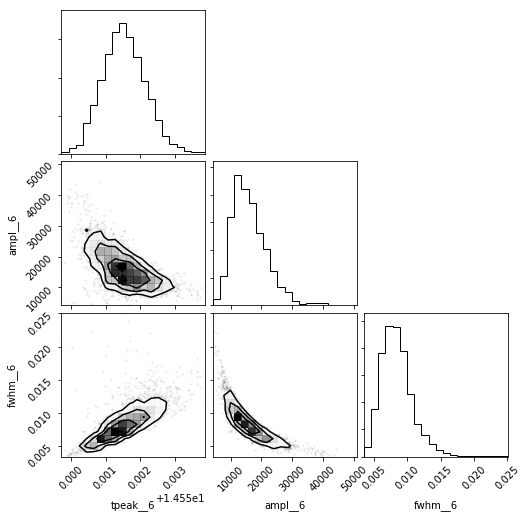

In [21]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

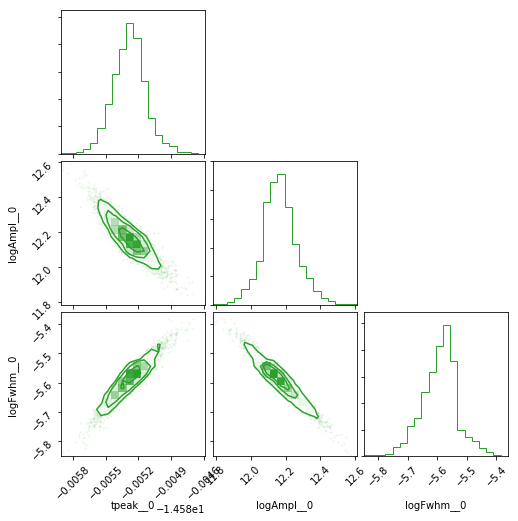

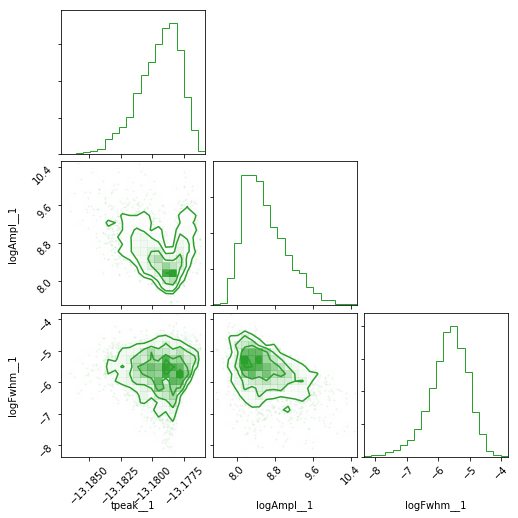

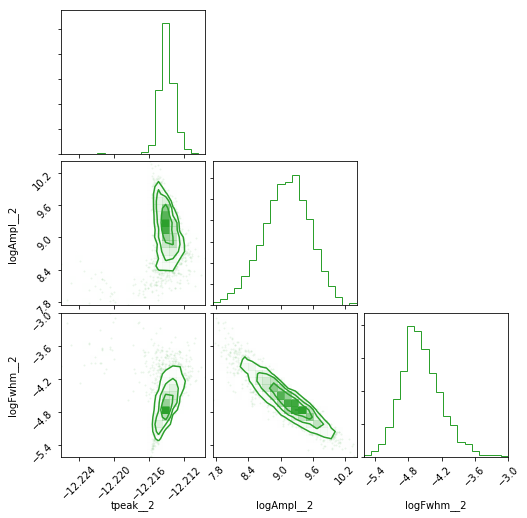

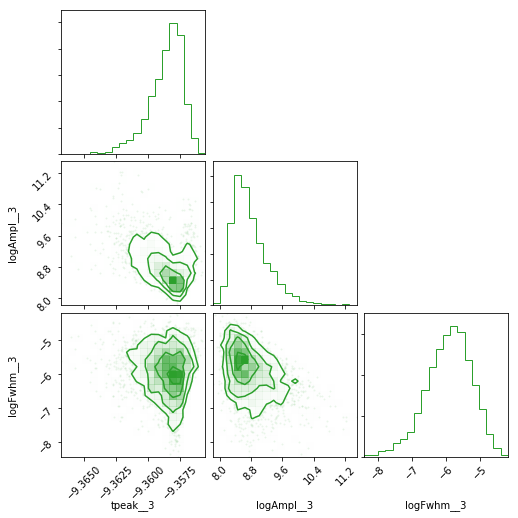

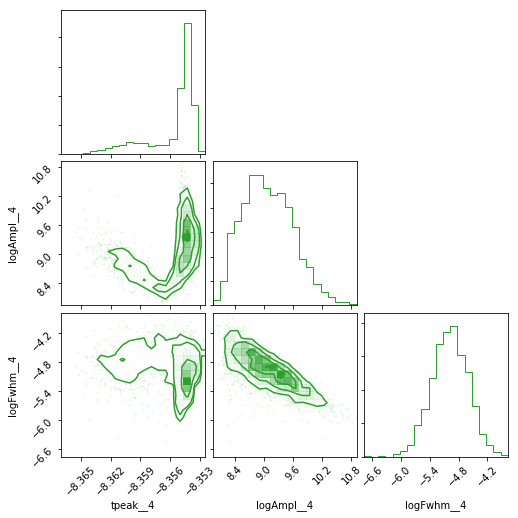

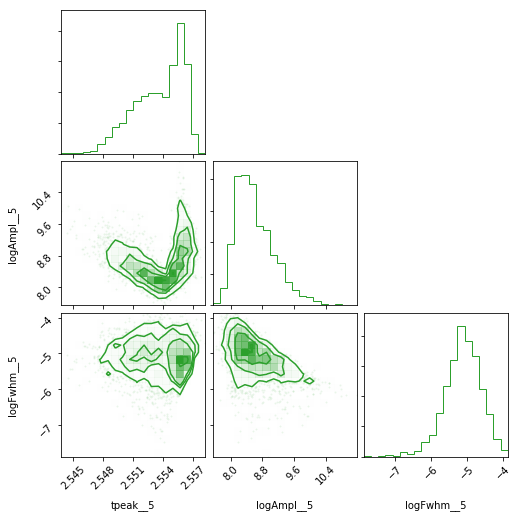

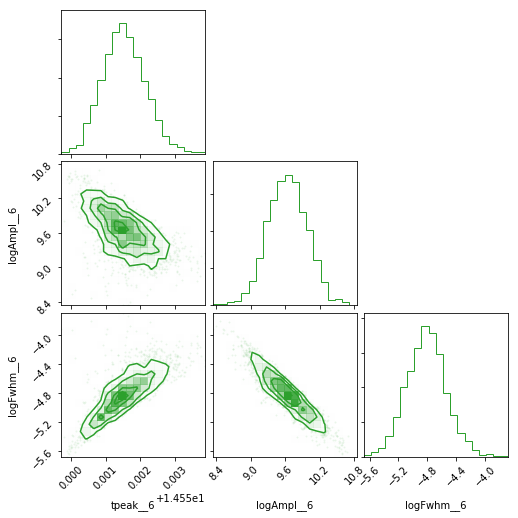

In [22]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');